In [1]:
import numpy as np
import torch as th
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt

from svpg.agents.env import EnvAgentAutoReset

from salina.workspace import Workspace
from salina.agents import Agents, TemporalAgent

In [50]:
def plot_state_visitation(tsne, directory, algo_name, env_name, cmap="Reds"):
    directory += algo_name
    agents_dir = directory + "/agents/all_action_agent"

    with open(directory + "/rewards.npy", "rb") as f:
        rewards = np.mean(np.load(f), axis=1)

    bests = rewards.argsort()[-4:][::-1]

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    axes = fig.subplots(nrows=1, ncols=4, sharey=True)

    for i, ax in zip(bests, axes):
        workspace = Workspace()

        with open(agents_dir + f"/action_agent_{i}.pt", "rb") as f:
            agent = th.load(f).cpu()

        env_agent = EnvAgentAutoReset(
            env_name=env_name, max_episode_steps=100, n_envs=8
        )

        acq_agent = TemporalAgent(Agents(env_agent, agent))
        acq_agent.seed(432)

        acq_agent(workspace, t=0, n_steps=256, stochastic=True)

        obs = workspace["env/env_obs"]
        obs = th.reshape(obs, (obs.shape[0], -1))

        Y = tsne.fit_transform(obs)

        sns.kdeplot(ax=ax, x=Y[:, 0], y=Y[:, 1], cmap=cmap, bw_adjust=0.5)
        ax.axis("off")
        ax.set_title(f"#{i} ({round(rewards[i])})")

    plt.savefig(f"../plots/{algo_name}_state_visitation_test.jpg")
    plt.plot()


In [51]:
tsne = TSNE(
    n_components=2,
    init="random",
    random_state=0,
    perplexity=30,
    learning_rate="auto",
    n_iter=300,
)

In [56]:
directory = "../archives/22-05-05/18-19-58/"

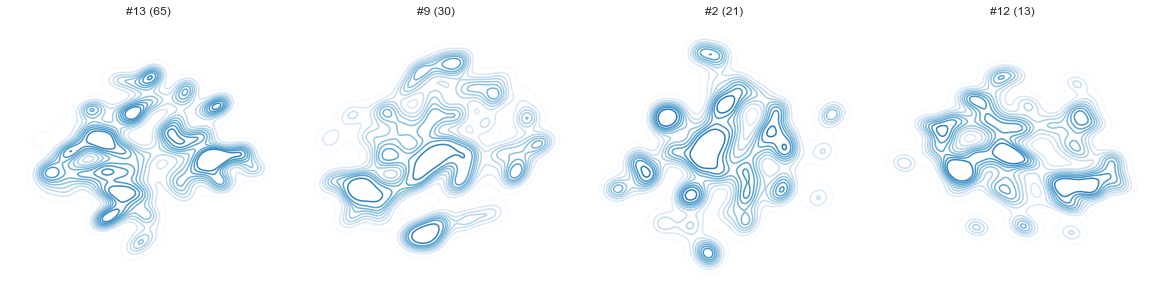

In [58]:
plot_state_visitation(tsne, directory, "algo_base", "CartPole-v1", cmap="Blues")


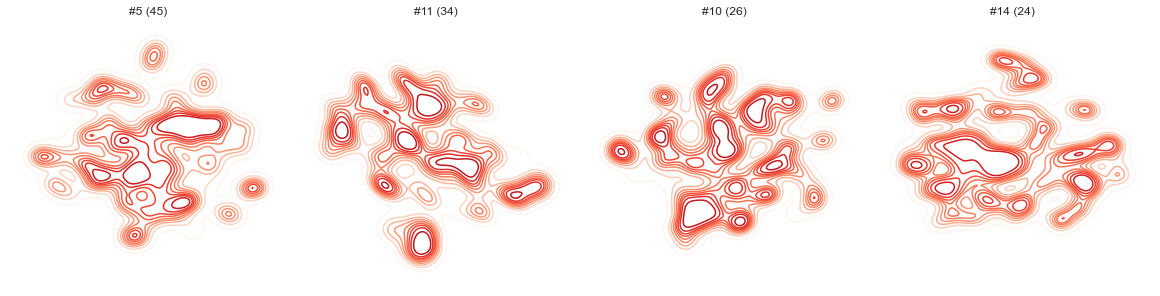

In [59]:
plot_state_visitation(tsne, directory, "svpg_annealed", "CartPole-v1", cmap="Reds")

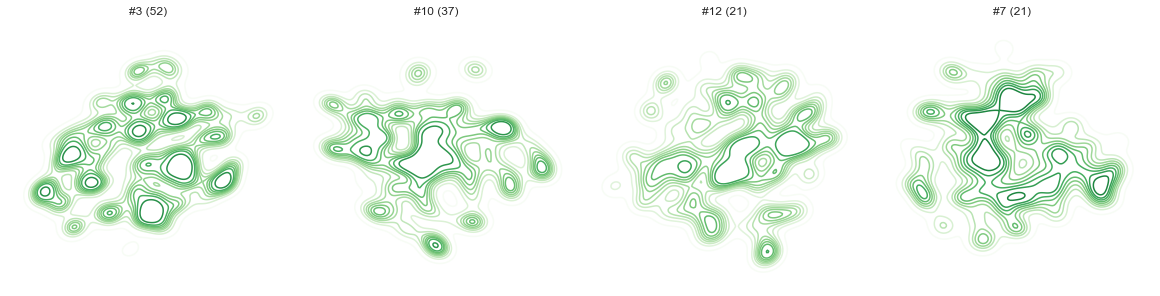

In [60]:
plot_state_visitation(tsne, directory, "svpg_normal", "CartPole-v1", cmap="Greens")